## Run Cellpose with appose

Now let's do something more exciting - run Cellpose segmentation using Appose! This shows how to send real data (an image) to another environment and get meaningful results back.

**Important:** Set your notebook kernel to 'Python (appose_napari_ai)' - this environment doesn't have Cellpose installed, which perfectly demonstrates calling Cellpose from a different environment!

### Load Libraries and Check Local Environment

First, let's import what we need. Notice we check if cellpose is available locally - it probably isn't, and that's okay! We'll run it in another environment.

In [1]:
from skimage.io import imread
from matplotlib import pyplot as plt
import appose

try:
    import cellpose
except ImportError:
    print("Cellpose is not installed.")

Cellpose is not installed.


### Load Our Test Image

Let's load the same cell image we've been using. This will be sent to the Cellpose environment for segmentation.

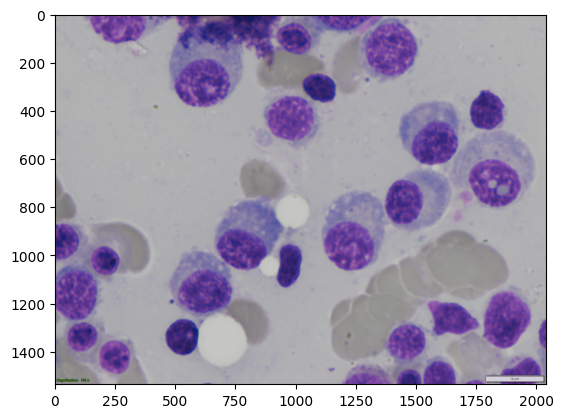

In [2]:
image_path = r"..\..\data\SOTA_segmentation\cell_00068.bmp"
img = imread(image_path)
plt.imshow(img)

### Write the Cellpose Code

We write Cellpose code as a string that will run in the other environment. Note how we get the result back through `task.outputs`.

In [3]:
# Create the execution string
execution_string = f'''
import numpy as np
from cellpose import models
import appose

model = models.CellposeModel(gpu=True)
    
masks, flows, styles = model.eval(
        image.ndarray(),
        #diameter=30,
        flow_threshold=0.5,
        niter=200
)

# Convert result to appose format for output

ndarr_mask = appose.NDArray(dtype=str(masks.dtype), shape=masks.shape)
ndarr_mask.ndarray()[:] = masks

task.outputs["mask"] = ndarr_mask
'''


### Prepare the Image for Sending

We need to convert our image into Appose's format so it can be sent to the other environment. 

In [4]:

cellpose_env_path = r"..\..\pixi\microsam_cellposesam\.pixi\envs\default"

env = appose.base(cellpose_env_path).build()
ndarr_img = appose.NDArray(dtype=str(img.dtype), shape=img.shape)
ndarr_img.ndarray()[:] = img

# Always include image, optionally add additional inputs
inputs = {"image": ndarr_img}


### Run Cellpose in the Other Environment

Now we send our image and code to the Cellpose environment, wait for it to finish, and get our segmentation mask back.

In [5]:
with env.python() as python:
    task = python.task(execution_string, inputs=inputs, queue="main")
    task.wait_for()

    if task.error:
        print(f"⚠️  Task error: {task.error}")

    print(task.outputs.keys())

    result = task.outputs.get("mask", None)


dict_keys(['mask'])


### Compare Results

Let's see how well our Appose-powered Cellpose did! We'll compare it side-by-side with the ground truth.

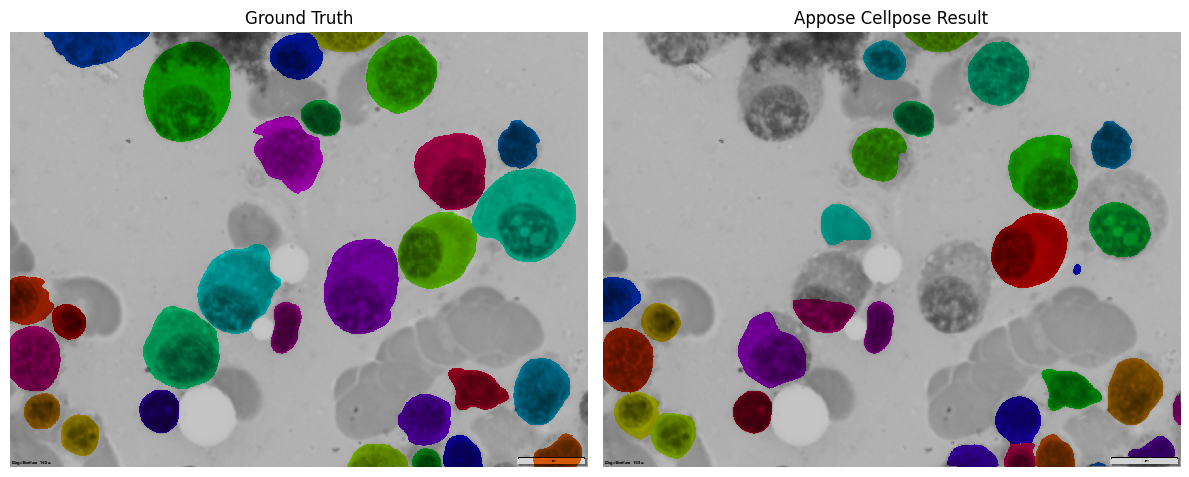

In [6]:
# Load ground truth for comparison
label_path = r"..\..\data\SOTA_segmentation\cell_00068_label.tiff"
ground_truth = imread(label_path)

# Import visualization helper
from tnia.plotting.plt_helper import mask_overlay

# Create overlays
ground_truth_overlay = mask_overlay(img, ground_truth)
result_overlay = mask_overlay(img, result.ndarray())

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(ground_truth_overlay)
axes[0].set_title('Ground Truth')
axes[0].axis('off')

axes[1].imshow(result_overlay)
axes[1].set_title('Appose Cellpose Result')
axes[1].axis('off')

plt.tight_layout()
plt.show()